In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from dwave.embedding.chain_breaks import majority_vote, broken_chains
import dimod
from joblib import load

densities = [round(0.05 + 0.05*i, 2) for i in range(20)]  # 20
sizes = [25+10*i for i in range(16)] # 16

def unembed_sampleset_mine(sampleset, embedding, bqm, chain_break_fraction=False):
    variables = list(bqm.variables)  # need this ordered
    try:
        chains = [embedding[v] for v in variables]
    except KeyError:
        raise ValueError("given bqm does not match the embedding")

    record = sampleset.record

    unembedded, idxs = majority_vote(sampleset, chains)

    reserved = {'sample', 'energy'}
    vectors = {name: record[name][idxs]
            for name in record.dtype.names if name not in reserved}
    
    if chain_break_fraction:
        broken = broken_chains(sampleset, chains)
        if broken.size:
            vectors['chain_break_fraction'] = broken.mean(axis=1)[idxs]
        else:
            vectors['chain_break_fraction'] = 0

    info = sampleset.info.copy()

    return dimod.SampleSet.from_samples_bqm((unembedded, variables),
                                            bqm,
                                            info=info,
                                            **vectors)



In [9]:
data = load('pickles/RQ1.1_extended.joblib')
acl, num_qubits, energies, unembedded_energies, reference_energies, relative_errors, unembedded_relative_errors, broken_chain_fractions = data

median_relative_errors = np.median(relative_errors, axis = -1)
median_unembedded_relative_errors = np.median(unembedded_relative_errors, axis = -1)
median_broken_chain_fractions = np.median(broken_chain_fractions, axis = -1)

min_relative_errors = np.min(relative_errors, axis = -1)
min_unembedded_relative_errors = np.min(unembedded_relative_errors, axis = -1)
min_broken_chain_fractions = np.min(broken_chain_fractions, axis = -1)

Coefficients: a = 0.4861509903903699, b = 0.025735090891443973, c = -0.4915985054052235
R-squared: 0.9817937040914162


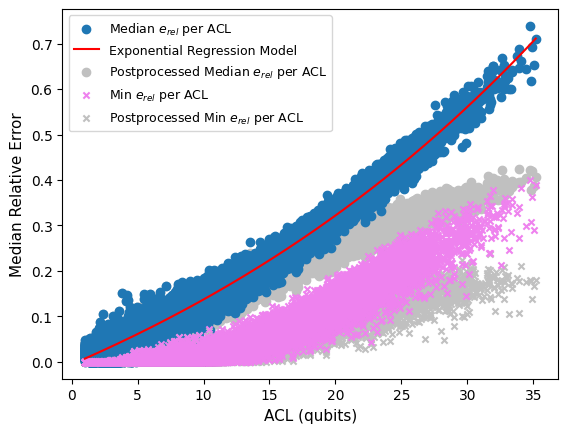

In [10]:
plt.figure()
plt.scatter(acl, median_unembedded_relative_errors[:,:,:,:,0], label=r'Postprocessed Median $e_{rel}$ per ACL', color='silver')

def exponential_model(n_qubits, a, b, c):
    return a * np.exp(b * n_qubits) + c

acl_ordered_, median_relative_errors_ordered_ = (np.array(t) for t in zip(*sorted(zip(acl[~np.isnan(acl)].flatten(), median_relative_errors[:,:,:,:,0][~np.isnan(median_relative_errors[:,:,:,:,0])].flatten()))))

# Fit the exponential model to the data
params, covariance = curve_fit(exponential_model, acl_ordered_, median_relative_errors_ordered_)

# Extract the coefficients
a, b, c = params

# Print the coefficients
print(f"Coefficients: a = {a}, b = {b}, c = {c}")

# Predict values using the fitted model
fitted_values = exponential_model(acl_ordered_, a, b, c)

# Plot the original data and the fitted model

plt.scatter(acl_ordered_, median_relative_errors_ordered_, label=r'Median $e_{rel}$ per ACL')
plt.plot(acl_ordered_, fitted_values, color='red', label='Exponential Regression Model')
plt.xlabel('ACL (qubits)', fontsize=11)
plt.ylabel(r'Median Relative Error', fontsize=11)

# # Calculate the R-squared value
ss_res = np.sum((median_relative_errors_ordered_ - fitted_values) ** 2)
ss_tot = np.sum((median_relative_errors_ordered_ - np.mean(median_relative_errors_ordered_)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

# Print the R-squared value
print(f"R-squared: {r_squared}")

plt.scatter(acl, min_unembedded_relative_errors[:, :, :, :, 0], 
                  label=r'Postprocessed Min $e_{rel}$ per ACL', color='silver', marker='x', s=20)
plt.scatter(acl, min_relative_errors[:, :, :, :, 0], 
                  label=r'Min $e_{rel}$ per ACL', color='violet', marker='x', s=20)

# Change the order of the legend items
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 2, 0, 4, 3]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize=9)
# plt.legend(loc='upper right', bbox_to_anchor=(1.97, 1.02))

# plt.savefig('exponential.pdf', format='pdf')
plt.show()

How does size of problem matter? Is it the same a small problem with high ACL and a larger problem with lower ACL?

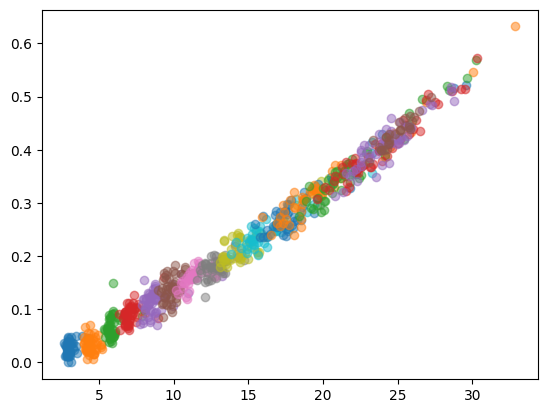

In [29]:
for size in range(16):
    plt.scatter(acl[10,size], median_relative_errors[10,size,:,:,0], label=f'Size {sizes[size]}', alpha=0.5)

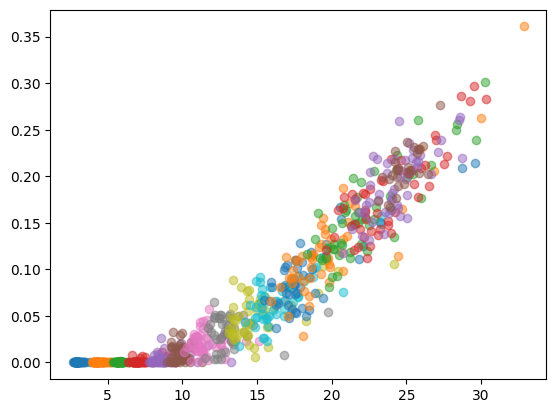

In [30]:
for size in range(16):
    plt.scatter(acl[10,size], min_relative_errors[10,size,:,:,0], label=f'Size {sizes[size]}', alpha=0.5)

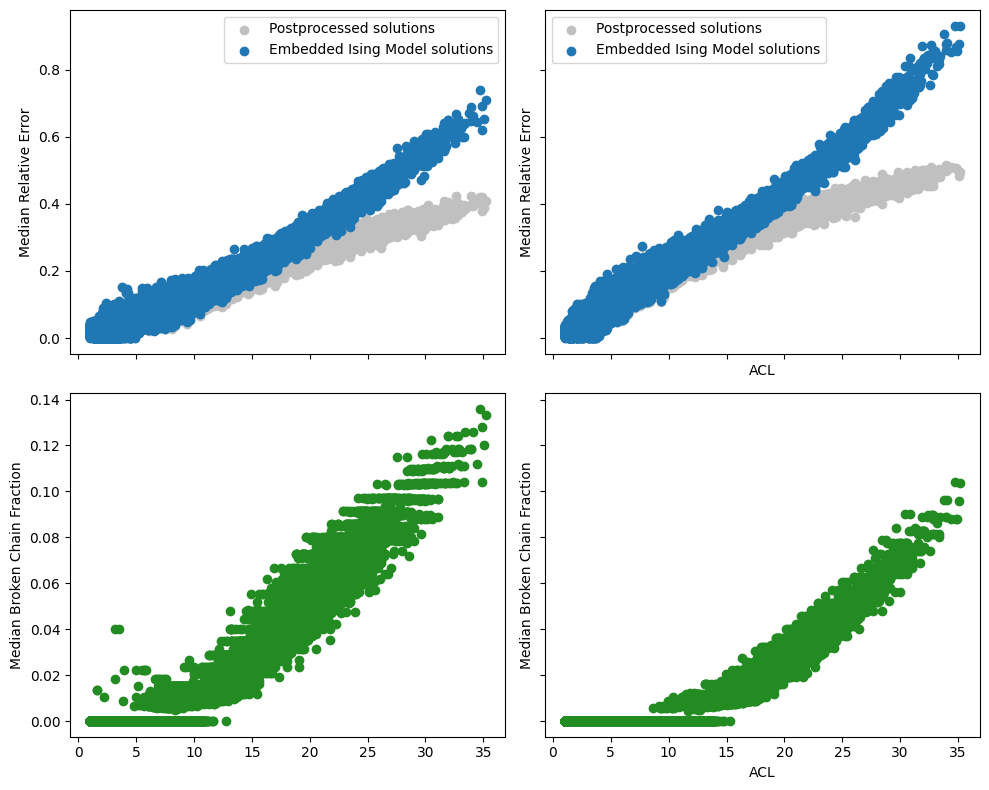

In [31]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 8))

# Top-left (0, 0)
axs[0, 0].scatter(acl, median_unembedded_relative_errors[:, :, :, :, 0], label='Postprocessed solutions', color='silver')
axs[0, 0].scatter(acl, median_relative_errors[:, :, :, :, 0], label='Embedded Ising Model solutions')
axs[0, 0].set_ylabel('Median Relative Error')
axs[0, 0].legend()

# Bottom-left (1, 0)
axs[1, 0].scatter(acl, median_broken_chain_fractions[:, :, :, :, 0] ,color = 'forestgreen')
axs[1, 0].set_ylabel('Median Broken Chain Fraction')

# Top-right (0, 1)
axs[0, 1].scatter(acl, median_unembedded_relative_errors[:, :, :, :, 1], label='Postprocessed solutions', color='silver')
axs[0, 1].scatter(acl, median_relative_errors[:, :, :, :, 1], label='Embedded Ising Model solutions')
axs[0, 1].set_xlabel('ACL')
axs[0, 1].set_ylabel('Median Relative Error')
axs[0, 1].legend()

# Bottom-right (1, 1)
axs[1, 1].scatter(acl, median_broken_chain_fractions[:, :, :, :, 1], color='forestgreen')
axs[1, 1].set_xlabel('ACL')
axs[1, 1].set_ylabel('Median Broken Chain Fraction')

plt.tight_layout()
plt.show()

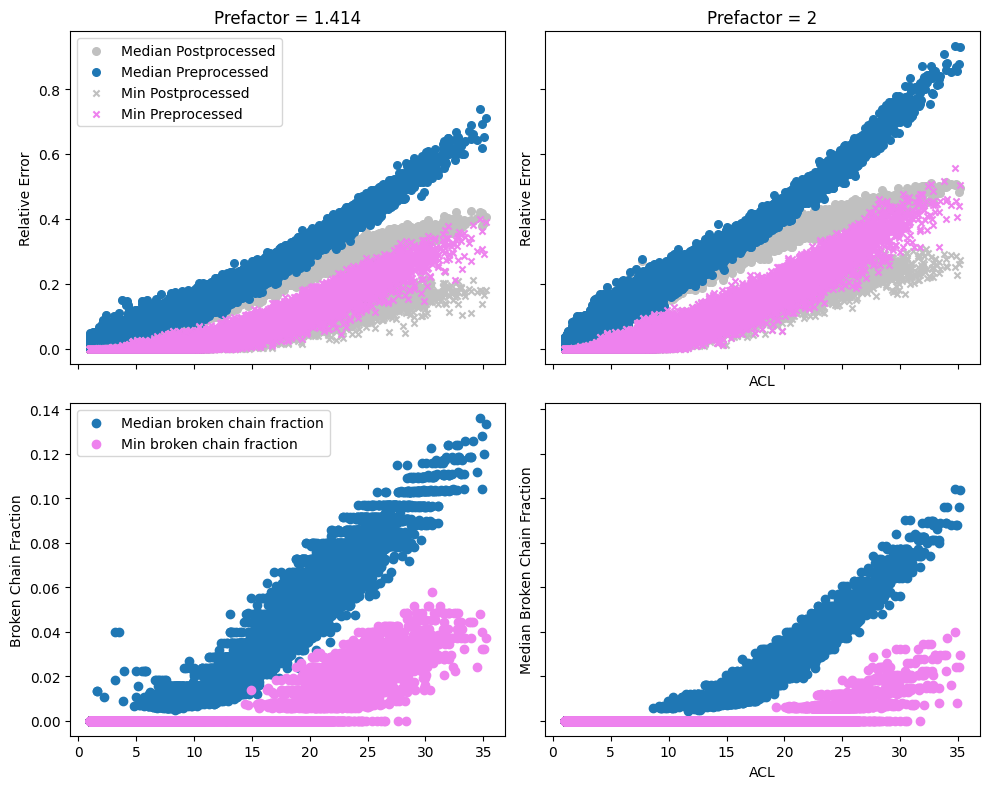

In [67]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 8))

# Top-left (0, 0)
axs[0, 0].scatter(acl, median_unembedded_relative_errors[:, :, :, :, 0], 
                  label='Median Postprocessed', color='silver', marker='o', s=30)
axs[0, 0].scatter(acl, median_relative_errors[:, :, :, :, 0], 
                  label='Median Preprocessed', color='tab:blue', marker='o', s=30)

axs[0, 0].scatter(acl, min_unembedded_relative_errors[:, :, :, :, 0], 
                  label='Min Postprocessed', color='silver', marker='x', s=20)
axs[0, 0].scatter(acl, min_relative_errors[:, :, :, :, 0], 
                  label='Min Preprocessed', color='violet', marker='x', s=20)
axs[0, 0].set_ylabel('Relative Error')
axs[0, 0].set_title('Prefactor = 1.414')
axs[0, 0].legend()

# Bottom-left (1, 0)
axs[1, 0].scatter(acl, median_broken_chain_fractions[:, :, :, :, 0] ,color = 'tab:blue', label = 'Median broken chain fraction')

axs[1, 0].scatter(acl, min_broken_chain_fractions[:, :, :, :, 0] ,color = 'violet', label = 'Min broken chain fraction')
axs[1, 0].set_ylabel('Broken Chain Fraction')
axs[1, 0].legend()


# Top-right (0, 1)
axs[0, 1].scatter(acl, median_unembedded_relative_errors[:, :, :, :, 1], 
                  label='Median Postprocessed', color='silver', marker='o', s=30)
axs[0, 1].scatter(acl, median_relative_errors[:, :, :, :, 1], 
                  label='Median Preprocessed', color='tab:blue', marker='o', s=30)

axs[0, 1].scatter(acl, min_unembedded_relative_errors[:, :, :, :, 1], 
                  label='Min Postprocessed', color='silver', marker='x', s=20)
axs[0, 1].scatter(acl, min_relative_errors[:, :, :, :, 1], 
                  label='Min Preprocessed', color='violet', marker='x', s=20)
axs[0, 1].set_ylabel('Relative Error')
axs[0, 1].set_xlabel('ACL')
axs[0, 1].set_title('Prefactor = 2')

# Bottom-right (1, 1)
axs[1, 1].scatter(acl, median_broken_chain_fractions[:, :, :, :, 1] ,color = 'tab:blue', label = 'Median broken chain fraction')

axs[1, 1].scatter(acl, min_broken_chain_fractions[:, :, :, :, 1] ,color = 'violet', label = 'Min broken chain fraction')

axs[1, 1].set_xlabel('ACL')
axs[1, 1].set_ylabel('Median Broken Chain Fraction')

plt.tight_layout()
plt.show()

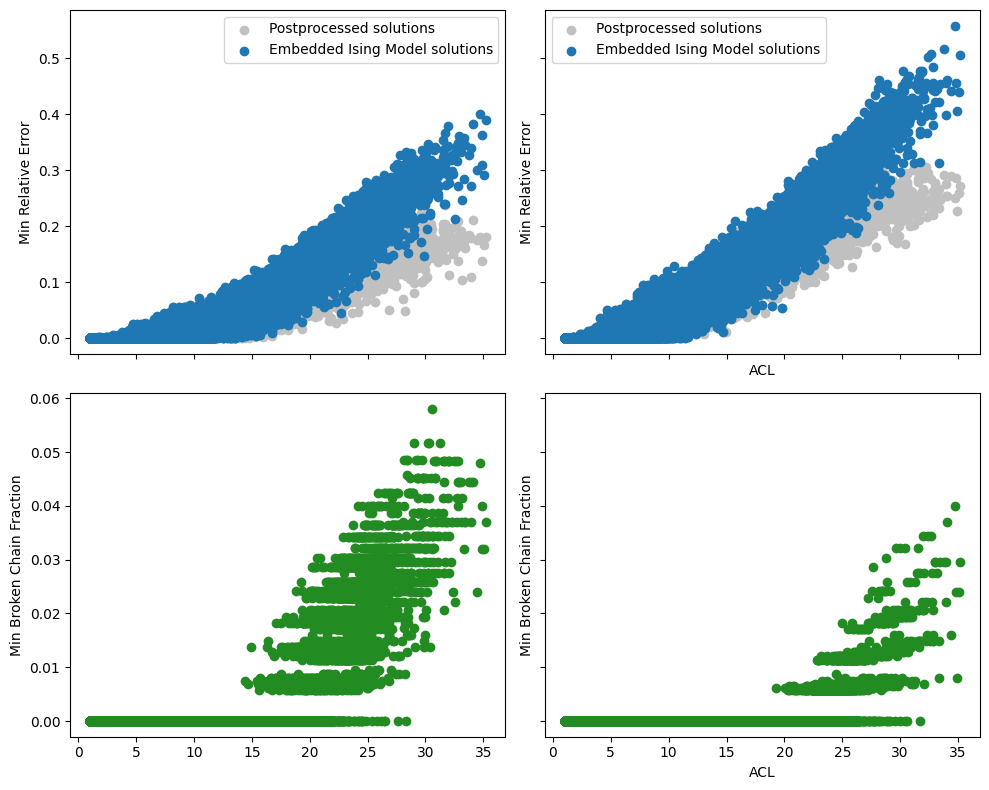

In [29]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 8))

# Top-left (0, 0)
axs[0, 0].scatter(acl, min_unembedded_relative_errors[:, :, :, :, 0], label='Postprocessed solutions', color='silver')
axs[0, 0].scatter(acl, min_relative_errors[:, :, :, :, 0], label='Embedded Ising Model solutions')
axs[0, 0].set_ylabel('Min Relative Error')
axs[0, 0].legend()

# Top-right (0, 1)
axs[1, 0].scatter(acl, min_broken_chain_fractions[:, :, :, :, 0], color='forestgreen')
axs[1, 0].set_ylabel('Min Broken Chain Fraction')

# Bottom-left (1, 0)
axs[0, 1].scatter(acl, min_unembedded_relative_errors[:, :, :, :, 1], label='Postprocessed solutions', color='silver')
axs[0, 1].scatter(acl, min_relative_errors[:, :, :, :, 1], label='Embedded Ising Model solutions')
axs[0, 1].set_xlabel('ACL')
axs[0, 1].set_ylabel('Min Relative Error')
axs[0, 1].legend()

# Bottom-right (1, 1)
axs[1, 1].scatter(acl, min_broken_chain_fractions[:, :, :, :, 1], color='forestgreen')
axs[1, 1].set_xlabel('ACL')
axs[1, 1].set_ylabel('Min Broken Chain Fraction')

plt.tight_layout()
plt.show()

C:\Users\aitor.gomez-tejedor\AppData\Local\Temp\ipykernel_22488\2442675197.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


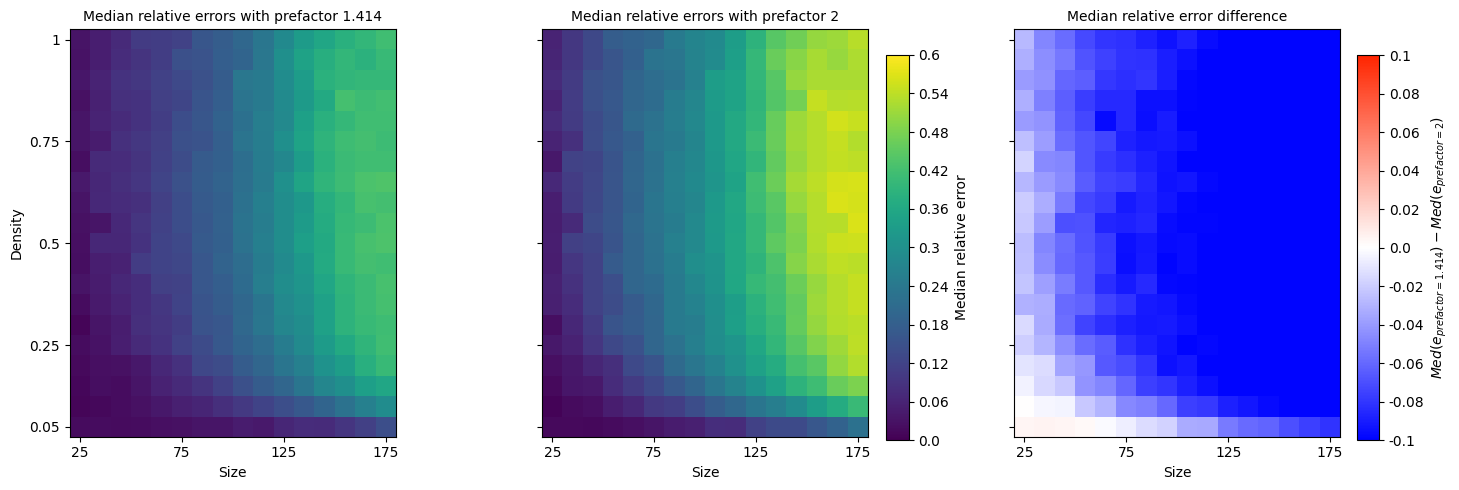

In [12]:
# Simulated data for structure (if you already have the data, skip this)
# median_relative_errors = np.random.rand(20, 20, 10, 10, 2)
# sizes = np.linspace(25, 200, 20)

vmin_shared = 0
vmax_shared = 0.6
vmin_diff = -0.1
vmax_diff = 0.1
prefactors = [1.414, 2]

# Custom colormap for the third image
jet = plt.get_cmap('jet')
blue_jet = jet(0.13)
red_jet = jet(0.87)
custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    'custom_bwr_like',
    [blue_jet, (1, 1, 1, 1), red_jet],
    N=256
)

# Create figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
ims = []

# Subplots 0 and 1 (direct comparison with shared colorbar)
for pref in range(2):
    im = axs[pref].imshow(np.nanmean(median_relative_errors, axis=(2,3))[:, :, pref],
                          vmin=vmin_shared, vmax=vmax_shared)
    ims.append(im)
    axs[pref].invert_yaxis()
    axs[pref].set_xlabel('Size', fontsize=10)
    axs[pref].set_xticks(range(0, len(sizes), 5))
    axs[pref].set_xticklabels([25, 75, 125, 175])
    axs[pref].set_title(f'Median relative errors with prefactor {prefactors[pref]}', fontsize=10)

# Y-axis only on the first subplot
axs[0].set_ylabel('Density', fontsize=10)
axs[0].set_yticks([0, 4, 9, 14, 19])
axs[0].set_yticklabels([0.05, 0.25, 0.5, 0.75, 1])

# Shared colorbar for the first two subplots
cax_shared = fig.add_axes([axs[1].get_position().x1 + 0.02,
                           axs[1].get_position().y0,
                           0.015,
                           axs[1].get_position().height])
cbar_shared = fig.colorbar(ims[0], cax=cax_shared)
cbar_shared.set_label('Median relative error', fontsize=10)
cbar_shared.set_ticks(np.linspace(vmin_shared, vmax_shared, 11))
cbar_shared.set_ticklabels([round(i, 2) for i in np.linspace(vmin_shared, vmax_shared, 11)])

# Third subplot (difference between prefactors with its own colorbar)
diff_data = np.nanmean(median_relative_errors[:,:,:,:,0] - median_relative_errors[:,:,:,:,1], axis=(2,3))
im_diff = axs[2].imshow(diff_data, vmin=vmin_diff, vmax=vmax_diff, cmap=custom_cmap)
axs[2].invert_yaxis()
axs[2].set_xlabel('Size', fontsize=10)
axs[2].set_xticks(range(0, len(sizes), 5))
axs[2].set_xticklabels([25, 75, 125, 175])
axs[2].set_title('Median relative error difference', fontsize=10)

# Individual colorbar for the third image
cax_diff = fig.add_axes([axs[2].get_position().x1 + 0.06,
                         axs[2].get_position().y0,
                         0.015,
                         axs[2].get_position().height])
cbar_diff = fig.colorbar(im_diff, cax=cax_diff)
cbar_diff.set_label(r'$Med(e_{{prefactor = 1.414}}) - Med(e_{{prefactor = 2}})$', fontsize=10)
cbar_diff.set_ticks(np.linspace(vmin_diff, vmax_diff, 11))
cbar_diff.set_ticklabels([round(i, 4) for i in np.linspace(vmin_diff, vmax_diff, 11)])

plt.tight_layout()
plt.show()


C:\Users\aitor.gomez-tejedor\AppData\Local\Temp\ipykernel_22488\1951800464.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


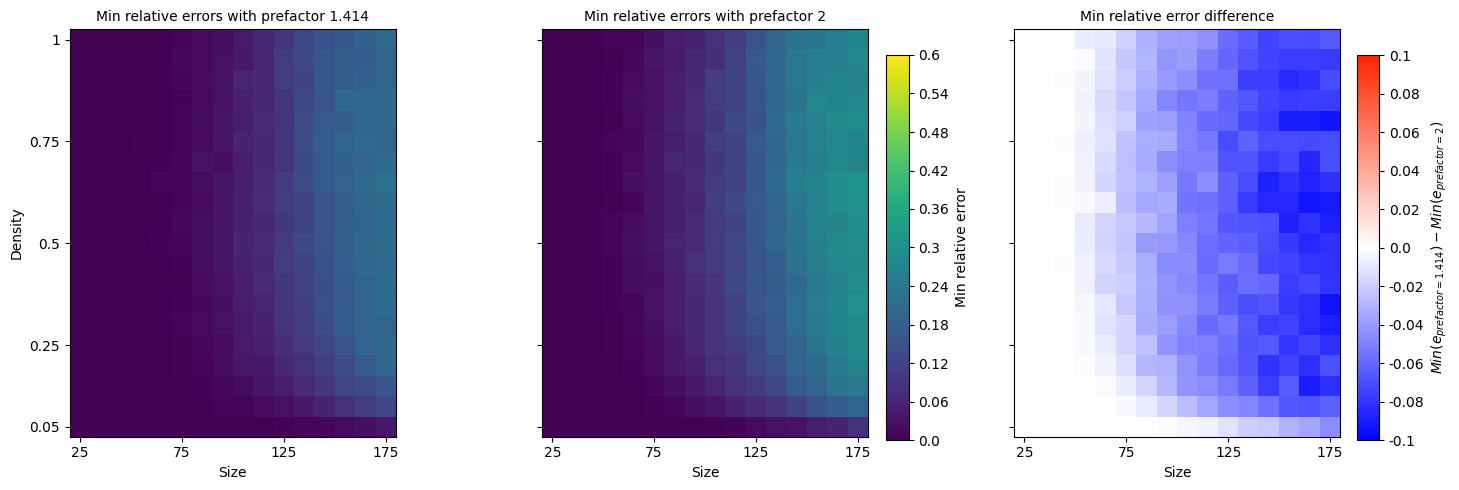

In [15]:
# Simulated data for structure (if you already have the data, skip this)
# median_relative_errors = np.random.rand(20, 20, 10, 10, 2)
# sizes = np.linspace(25, 200, 20)

vmin_shared = 0
vmax_shared = 0.6
vmin_diff = -0.1
vmax_diff = 0.1
prefactors = [1.414, 2]

# Custom colormap for the third image
jet = plt.get_cmap('jet')
blue_jet = jet(0.13)
red_jet = jet(0.87)
custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    'custom_bwr_like',
    [blue_jet, (1, 1, 1, 1), red_jet],
    N=256
)

# Create figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
ims = []

# Subplots 0 and 1 (direct comparison with shared colorbar)
for pref in range(2):
    im = axs[pref].imshow(np.nanmean(min_relative_errors, axis=(2,3))[:, :, pref],
                          vmin=vmin_shared, vmax=vmax_shared)
    ims.append(im)
    axs[pref].invert_yaxis()
    axs[pref].set_xlabel('Size', fontsize=10)
    axs[pref].set_xticks(range(0, len(sizes), 5))
    axs[pref].set_xticklabels([25, 75, 125, 175])
    axs[pref].set_title(f'Min relative errors with prefactor {prefactors[pref]}', fontsize=10)

# Y-axis only on the first subplot
axs[0].set_ylabel('Density', fontsize=10)
axs[0].set_yticks([0, 4, 9, 14, 19])
axs[0].set_yticklabels([0.05, 0.25, 0.5, 0.75, 1])

# Shared colorbar for the first two subplots
cax_shared = fig.add_axes([axs[1].get_position().x1 + 0.02,
                           axs[1].get_position().y0,
                           0.015,
                           axs[1].get_position().height])
cbar_shared = fig.colorbar(ims[0], cax=cax_shared)
cbar_shared.set_label('Min relative error', fontsize=10)
cbar_shared.set_ticks(np.linspace(vmin_shared, vmax_shared, 11))
cbar_shared.set_ticklabels([round(i, 2) for i in np.linspace(vmin_shared, vmax_shared, 11)])

# Third subplot (difference between prefactors with its own colorbar)
diff_data = np.nanmean(min_relative_errors[:,:,:,:,0] - min_relative_errors[:,:,:,:,1], axis=(2,3))
im_diff = axs[2].imshow(diff_data, vmin=vmin_diff, vmax=vmax_diff, cmap=custom_cmap)
axs[2].invert_yaxis()
axs[2].set_xlabel('Size', fontsize=10)
axs[2].set_xticks(range(0, len(sizes), 5))
axs[2].set_xticklabels([25, 75, 125, 175])
axs[2].set_title('Min relative error difference', fontsize=10)

# Individual colorbar for the third image
cax_diff = fig.add_axes([axs[2].get_position().x1 + 0.06,
                         axs[2].get_position().y0,
                         0.015,
                         axs[2].get_position().height])
cbar_diff = fig.colorbar(im_diff, cax=cax_diff)
cbar_diff.set_label(r'$Min(e_{{prefactor = 1.414}}) - Min(e_{{prefactor = 2}})$', fontsize=10)
cbar_diff.set_ticks(np.linspace(vmin_diff, vmax_diff, 11))
cbar_diff.set_ticklabels([round(i, 4) for i in np.linspace(vmin_diff, vmax_diff, 11)])

plt.tight_layout()
plt.show()


C:\Users\aitor.gomez-tejedor\AppData\Local\Temp\ipykernel_22488\2747351108.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


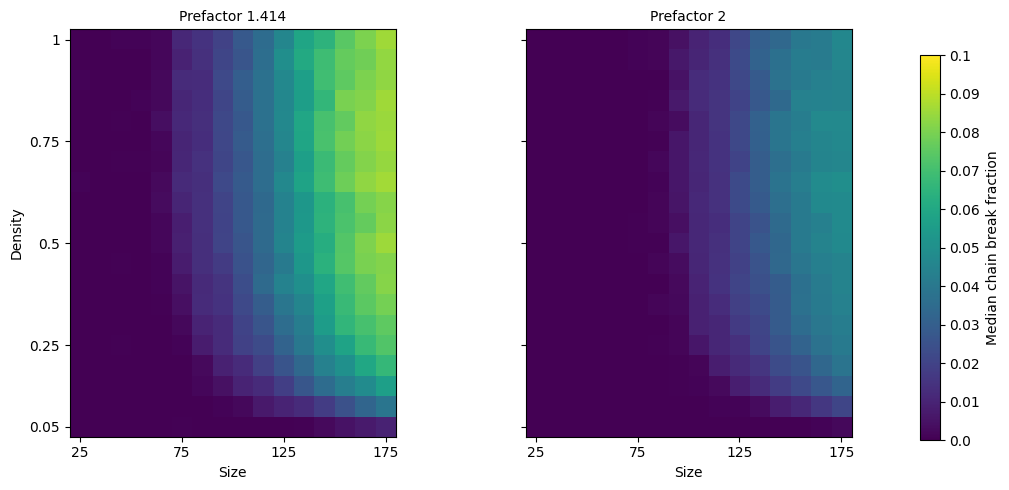

In [16]:
vmin = 0  # minimum value for the colorbar
vmax = 0.1  # maximum value for the colorbar

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
prefactors = [1.414, 2]

ims = []
for pref in range(2):
    im = axs[pref].imshow(np.nanmean(median_broken_chain_fractions, axis=(2,3))[:, :, pref], vmin=vmin, vmax=vmax)
    ims.append(im)
    axs[pref].invert_yaxis()
    axs[pref].set_xlabel('Size', fontsize=10)
    axs[pref].set_xticks(range(0, len(sizes), 5))
    axs[pref].set_xticklabels([25, 75, 125, 175])
    axs[pref].set_title(f'Prefactor {prefactors[pref]}', fontsize=10)

# Only one needs the Y-axis label
axs[0].set_ylabel('Density', fontsize=10)
axs[0].set_yticks([0, 4, 9, 14, 19])
axs[0].set_yticklabels([0.05, 0.25, 0.5, 0.75, 1])

# Add a single colorbar for both plots
cax = fig.add_axes([axs[1].get_position().x1+0.1, axs[1].get_position().y0, 0.02, axs[0].get_position().y1 - axs[1].get_position().y0])

cbar = fig.colorbar(ims[0], ax=axs.ravel().tolist(), cax=cax)
cbar.set_label('Median chain break fraction', fontsize=10)
cbar.set_ticks(np.linspace(vmin, vmax, 11))
cbar.set_ticklabels([round(i, 2) for i in np.linspace(vmin, vmax, 11)])

plt.tight_layout()
plt.show()


C:\Users\aitor.gomez-tejedor\AppData\Local\Temp\ipykernel_22488\3353948284.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


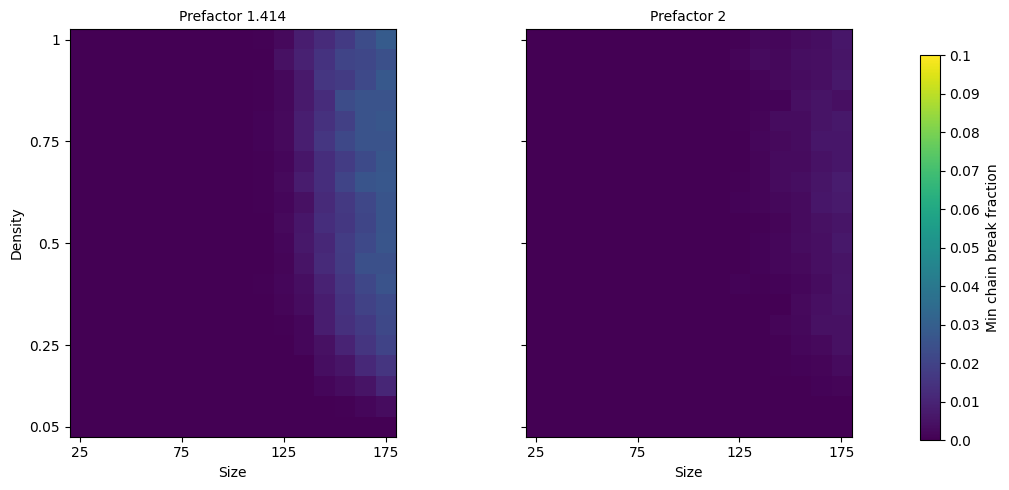

In [17]:
vmin = 0  # minimum value for the colorbar
vmax = 0.1  # maximum value for the colorbar

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
prefactors = [1.414, 2]

ims = []
for pref in range(2):
    im = axs[pref].imshow(np.nanmean(min_broken_chain_fractions, axis=(2,3))[:, :, pref], vmin=vmin, vmax=vmax)
    ims.append(im)
    axs[pref].invert_yaxis()
    axs[pref].set_xlabel('Size', fontsize=10)
    axs[pref].set_xticks(range(0, len(sizes), 5))
    axs[pref].set_xticklabels([25, 75, 125, 175])
    axs[pref].set_title(f'Prefactor {prefactors[pref]}', fontsize=10)

# Only one needs the Y-axis label
axs[0].set_ylabel('Density', fontsize=10)
axs[0].set_yticks([0, 4, 9, 14, 19])
axs[0].set_yticklabels([0.05, 0.25, 0.5, 0.75, 1])

# Add a single colorbar for both plots
cax = fig.add_axes([axs[1].get_position().x1+0.1, axs[1].get_position().y0, 0.02, axs[0].get_position().y1 - axs[1].get_position().y0])

cbar = fig.colorbar(ims[0], ax=axs.ravel().tolist(), cax=cax)
cbar.set_label('Min chain break fraction', fontsize=10)
cbar.set_ticks(np.linspace(vmin, vmax, 11))
cbar.set_ticklabels([round(i, 2) for i in np.linspace(vmin, vmax, 11)])

plt.tight_layout()
plt.show()
